# DSS Thesis - Koen de Bonth

### Import packages

In [3]:
import os
from pathlib import Path
from utils import data_loader_utils
import itertools 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt

### Loading and Preparing Data

In [5]:
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]

#path on mac
# path_to_dataset = r"/Volumes/THESIS_KOEN/DSS_Thesis_CNC/data"

# path on windows
path_to_dataset = r"E:\DSS_Thesis_CNC\data"

X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label)
    X_data.extend(data_list)
    y_data.extend(data_label)

### Metadata Extraction

In [46]:
# List to store metadata about each h5 file
file_metadata = []

# Sampling rate in Hz for the measurements
SAMPLING_RATE = 2000  

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    if os.path.exists(data_path):
        for file in os.listdir(data_path):
            if file.endswith('.h5'):
                fullpath = os.path.join(data_path, file)
                with h5py.File(fullpath, 'r') as f:
                    dataset_name = list(f.keys())[0]
                    dataset = f[dataset_name]
                    
                    file_metadata.append({
                        'machine': machine,
                        'operation': process_name,
                        'class': label,
                        'measurements': dataset.shape[0],
                        'channels': dataset.shape[1] if len(dataset.shape) > 1 else 1,
                        'duration_sec': dataset.shape[0] / SAMPLING_RATE,  # Duration in seconds
                        'duration_min': dataset.shape[0] / SAMPLING_RATE / 60,  # Duration in minutes 
                        'file_size_mb': os.path.getsize(fullpath) / (1024 * 1024),
                        'month_created': file.split('_')[1],
                        'year_created': file.split('_')[2],
                        'full_path': fullpath
                    })

# Create dataframe with file metadata
df_measurement_files = pd.DataFrame(file_metadata)
df_measurement_files.to_csv('measurement_files_metadata.csv', index=False)

# display(df_measurement_files)

## Feature Extraction

In [13]:
x = X_data[0]

wp = pywt.WaveletPacket(data=x, wavelet='coif8', mode='symmetric')

print(x.shape)
print(wp.maxlevel)

(268288, 3)
0


Shape of wavelet features: (3, 36)


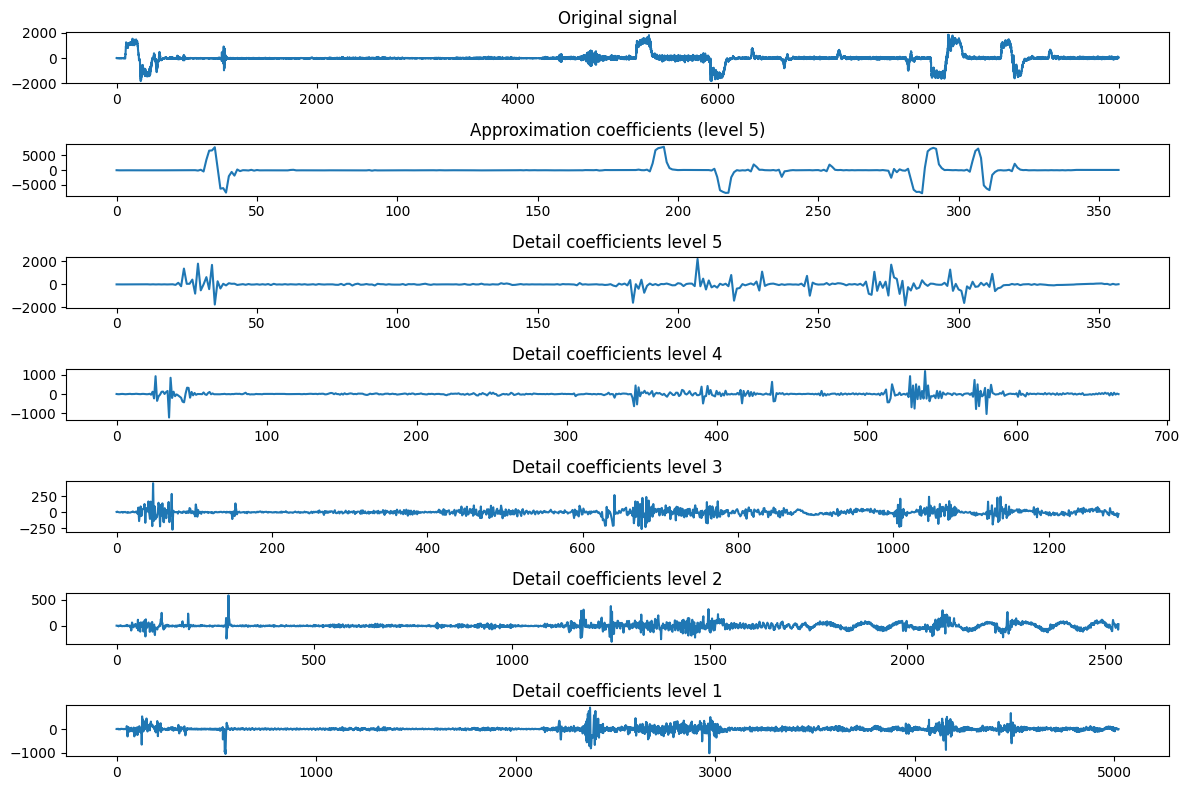

In [18]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy import signal

# Assuming x is your data with shape (268288, 3)
# We will apply the wavelet transform on each channel

# Parameters
wavelet = 'coif8'  # Wavelet type
level = 5          # Decomposition level

# Function to extract wavelet features
def extract_wavelet_features(signal_data, wavelet_type=wavelet, level=5):
    # Apply the wavelet transform
    coeffs = pywt.wavedec(signal_data, wavelet=wavelet_type, level=level)
    
    # Extract features from each coefficient set
    features = []
    
    for i, coeff in enumerate(coeffs):
        # Calculate statistical features for each coefficient set
        features.append(np.mean(coeff))       # Mean
        features.append(np.std(coeff))        # Standard deviation
        features.append(np.max(coeff))        # Maximum
        features.append(np.min(coeff))        # Minimum
        features.append(np.median(coeff))     # Median
        features.append(np.sum(coeff**2))     # Energy
    
    return np.array(features)

# Apply to each channel of x

wavelet_features = []

for channel in range(x.shape[1]):
    channel_data = x[:, channel]
    channel_features = extract_wavelet_features(channel_data, wavelet, level)
    wavelet_features.append(channel_features)

wavelet_features = np.array(wavelet_features)
print(f"Shape of wavelet features: {wavelet_features.shape}")

# Visualization of the wavelet decomposition for the first channel
def plot_wavelet_decomposition(data, wavelet_type=wavelet, level=5):
    # Wavelet decomposition
    coeffs = pywt.wavedec(data, wavelet=wavelet_type, level=level)
    
    # Plot the original data and wavelet coefficients
    plt.figure(figsize=(12, 8))
    
    # Original data
    plt.subplot(level+2, 1, 1)
    plt.plot(data)
    plt.title('Original signal')
    
    # Approximation coefficients
    plt.subplot(level+2, 1, 2)
    plt.plot(coeffs[0])
    plt.title(f'Approximation coefficients (level {level})')
    
    # Detail coefficients
    for i in range(level):
        plt.subplot(level+2, 1, i+3)
        plt.plot(coeffs[i+1])
        plt.title(f'Detail coefficients level {level-i}')
    
    plt.tight_layout()
    plt.show()

# Visualize the first 10000 datapoints of the first channel for better display
plot_wavelet_decomposition(x[:10000, 0], wavelet, level)


Aantal geëxtraheerde features: 144
Eerste paar feature namen: ['ch1_coif8_A3_mean', 'ch1_coif8_A3_std', 'ch1_coif8_A3_max', 'ch1_coif8_A3_min', 'ch1_coif8_A3_energy', 'ch1_coif8_A3_entropy', 'ch1_coif8_D3_mean', 'ch1_coif8_D3_std', 'ch1_coif8_D3_max', 'ch1_coif8_D3_min']


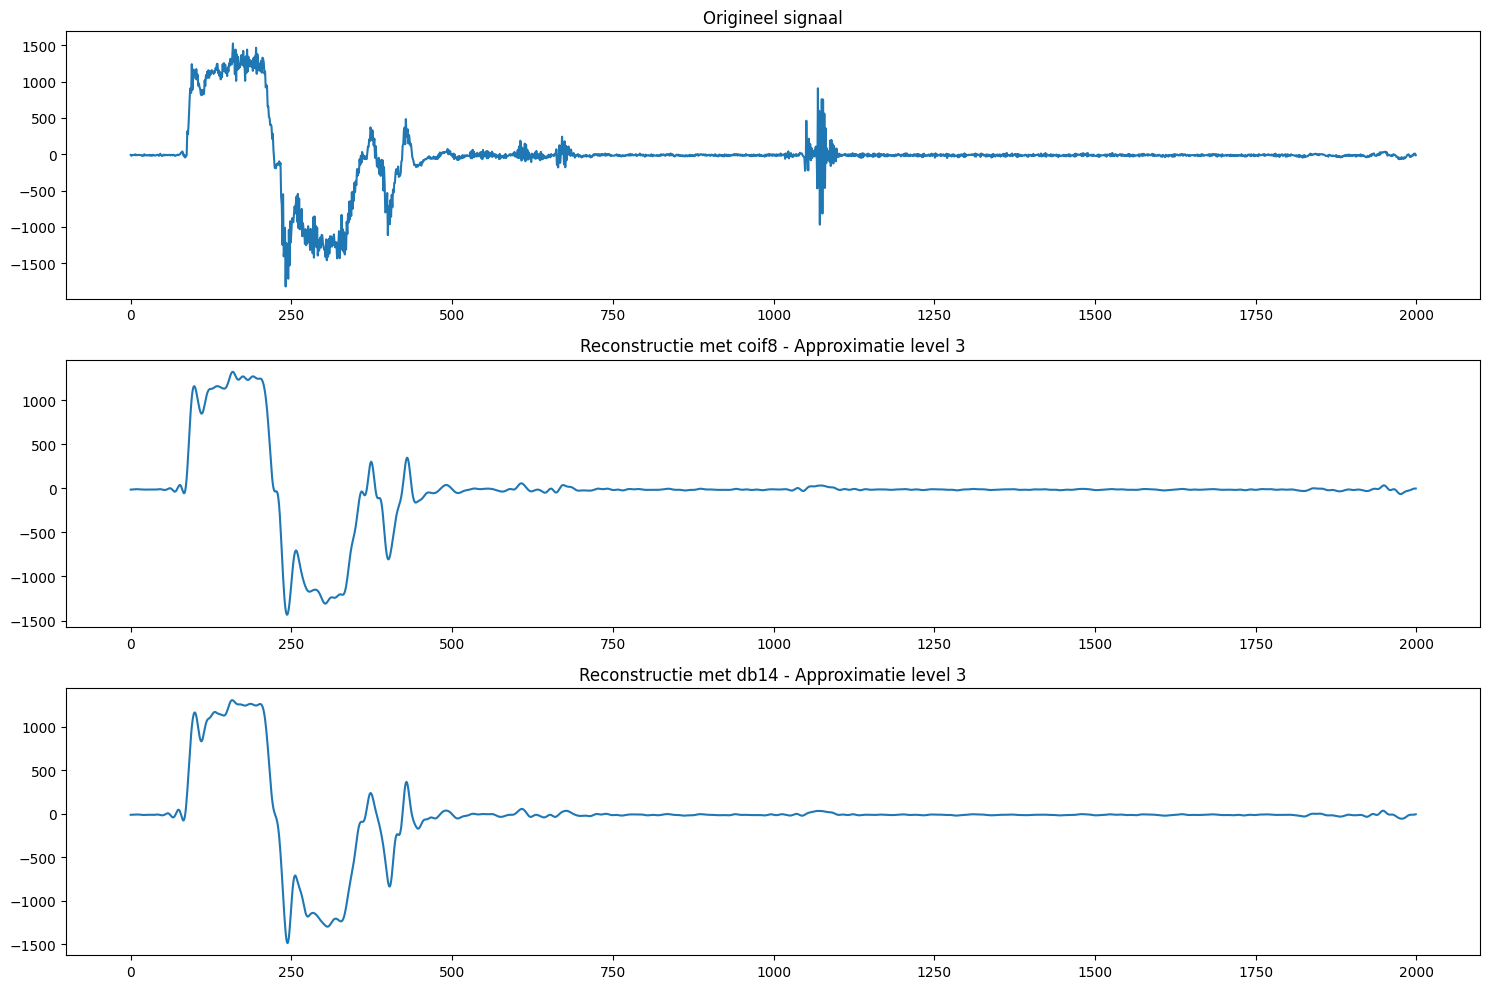

In [29]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def extract_optimized_wavelet_features(signal_data, sampling_rate=2000):
    """
    Extraheert wavelet features met de optimale wavelets (coif8 en db14) op level 3,
    gebaseerd op de beste prestaties met RF en Light GBM modellen.
    
    Parameters:
    signal_data - Het signaal om te analyseren
    sampling_rate - Sampling rate van het signaal (standaard: 2000 Hz)
    
    Returns:
    Een array met gecombineerde wavelet features
    """
    # Optimale wavelets en niveau
    wavelets = ['coif8', 'db14']
    level = 3
    
    all_features = []
    feature_names = []
    
    for wavelet in wavelets:
        # Pas de wavelet transform toe
        coeffs = pywt.wavedec(signal_data, wavelet=wavelet, level=level)
        
        # Extract features van elke coefficient set
        wavelet_features = []
        
        for i, coeff in enumerate(coeffs):
            # Naam van de coefficient set (approximatie of detail niveau)
            level_name = 'A' + str(level) if i == 0 else 'D' + str(level - i + 1)
            
            # Bereken kenmerken
            mean_val = np.mean(coeff)
            std_val = np.std(coeff)
            max_val = np.max(coeff)
            min_val = np.min(coeff)
            energy = np.sum(coeff**2)
            entropy = -np.sum(coeff**2 * np.log(coeff**2 + 1e-10))
            
            # Voeg features toe
            wavelet_features.extend([mean_val, std_val, max_val, min_val, energy, entropy])
            
            # Voeg feature namen toe voor latere identificatie
            prefix = f"{wavelet}_{level_name}"
            feature_names.extend([
                f"{prefix}_mean", f"{prefix}_std", f"{prefix}_max", 
                f"{prefix}_min", f"{prefix}_energy", f"{prefix}_entropy"
            ])
        
        all_features.extend(wavelet_features)
    
    return np.array(all_features), feature_names

# Functie om wavelet features toe te passen op meerdere kanalen
def apply_wavelets_to_channels(x, sampling_rate=2000):
    """
    Past wavelet feature extractie toe op elk kanaal van een multikanaals signaal
    
    Parameters:
    x - Data met vorm (samples, channels)
    sampling_rate - Sample rate van het signaal
    
    Returns:
    Een array met wavelet features voor elk kanaal
    """
    n_channels = x.shape[1]
    channel_features = []
    all_feature_names = []
    
    for channel in range(n_channels):
        channel_data = x[:, channel]
        features, feature_names = extract_optimized_wavelet_features(channel_data, sampling_rate)
        
        # Voeg kanaalnummer toe aan feature namen
        channel_feature_names = [f"ch{channel+1}_{name}" for name in feature_names]
        
        channel_features.append(features)
        all_feature_names.extend(channel_feature_names)
    
    # Combineer alle features in één array
    combined_features = np.concatenate(channel_features)
    
    return combined_features, all_feature_names

# Functie om resultaten te visualiseren
def visualize_wavelet_decomposition(signal, wavelets=['coif8', 'db14'], level=3):
    plt.figure(figsize=(15, 10))
    
    # Plot origineel signaal
    plt.subplot(len(wavelets) + 1, 1, 1)
    plt.plot(signal)
    plt.title("Origineel signaal")
    
    # Plot wavelet decomposities
    for i, wavelet in enumerate(wavelets):
        coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
        
        plt.subplot(len(wavelets) + 1, 1, i + 2)
        # Plot approximation op level 3
        reconstructed = pywt.waverec([coeffs[0]] + [None] * level, wavelet)
        plt.plot(reconstructed[:len(signal)])
        plt.title(f"Reconstructie met {wavelet} - Approximatie level {level}")
    
    plt.tight_layout()
    plt.show()

# Voorbeeld gebruik:
features, feature_names = apply_wavelets_to_channels(x, 2000)
print(f"Aantal geëxtraheerde features: {len(features)}")
print(f"Eerste paar feature namen: {feature_names[:10]}")
#
# # Visualiseer de eerste 2000 samples van het eerste kanaal
visualize_wavelet_decomposition(x[:2000, 0])





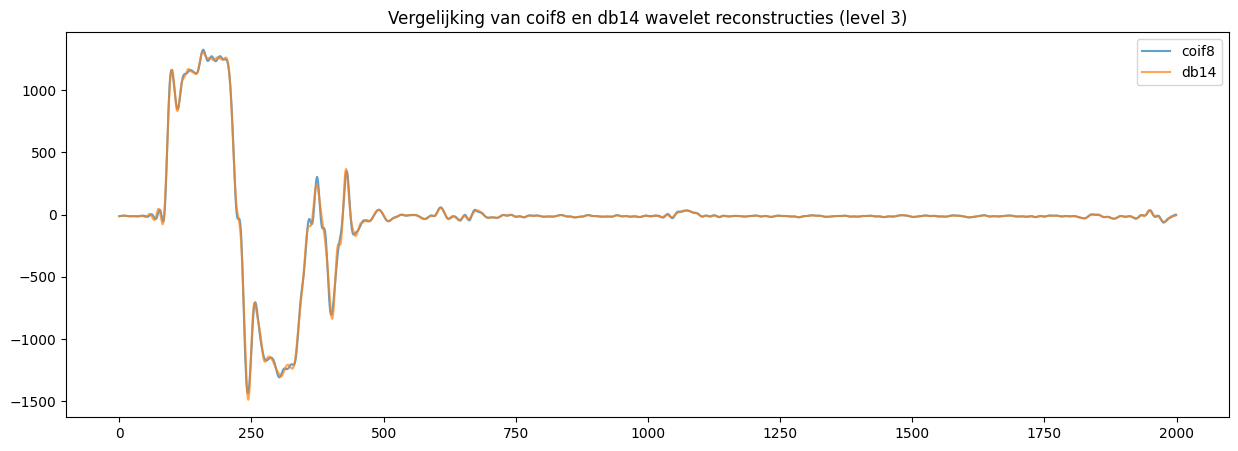

In [32]:
# Plot coif8 en db14 over elkaar voor vergelijking
plt.figure(figsize=(15, 5))

signal = x[:2000, 0]  # Gebruik zelfde signaal als hierboven

# Bereken wavelet decomposities
coif8_coeffs = pywt.wavedec(signal, wavelet='coif8', level=3)
db14_coeffs = pywt.wavedec(signal, wavelet='db14', level=3)

# Reconstrueer approximaties
coif8_reconstructed = pywt.waverec([coif8_coeffs[0]] + [None] * 3, 'coif8')
db14_reconstructed = pywt.waverec([db14_coeffs[0]] + [None] * 3, 'db14')

# Plot beide reconstructies over elkaar
plt.plot(coif8_reconstructed[:len(signal)], label='coif8', alpha=0.7)
plt.plot(db14_reconstructed[:len(signal)], label='db14', alpha=0.7)
plt.title("Vergelijking van coif8 en db14 wavelet reconstructies (level 3)")
plt.legend()
plt.show()

In [30]:
# Voeg wat nuttige analyses toe
print("\nSamenvatting van de dataset:")
print(f"Totaal aantal files: {len(df_measurement_files)}")
print(f"\nGemiddelde duur per meting: {df_measurement_files['duration_sec'].mean():.2f} seconden")
print(f"Standaard deviatie van duur: {df_measurement_files['duration_sec'].std():.2f} seconden")
print(f"\nAantal kanalen per meting: {df_measurement_files['channels'].value_counts().to_dict()}")

# Visualisatie van de duur van metingen
plt.figure(figsize=(10, 5))
plt.hist(df_measurement_files['duration_sec'], bins=50)
plt.title('Distributie van meting duraties')
plt.xlabel('Duratie (seconden)')
plt.ylabel('Aantal files')
plt.show()

# Boxplot van duur per operatie
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_measurement_files, x='operation', y='duration_sec')
plt.xticks(rotation=45)
plt.title('Duratie per operatie')
plt.xlabel('Operatie')
plt.ylabel('Duratie (seconden)')
plt.show()


Samenvatting van de dataset:


NameError: name 'df_measurement_files' is not defined

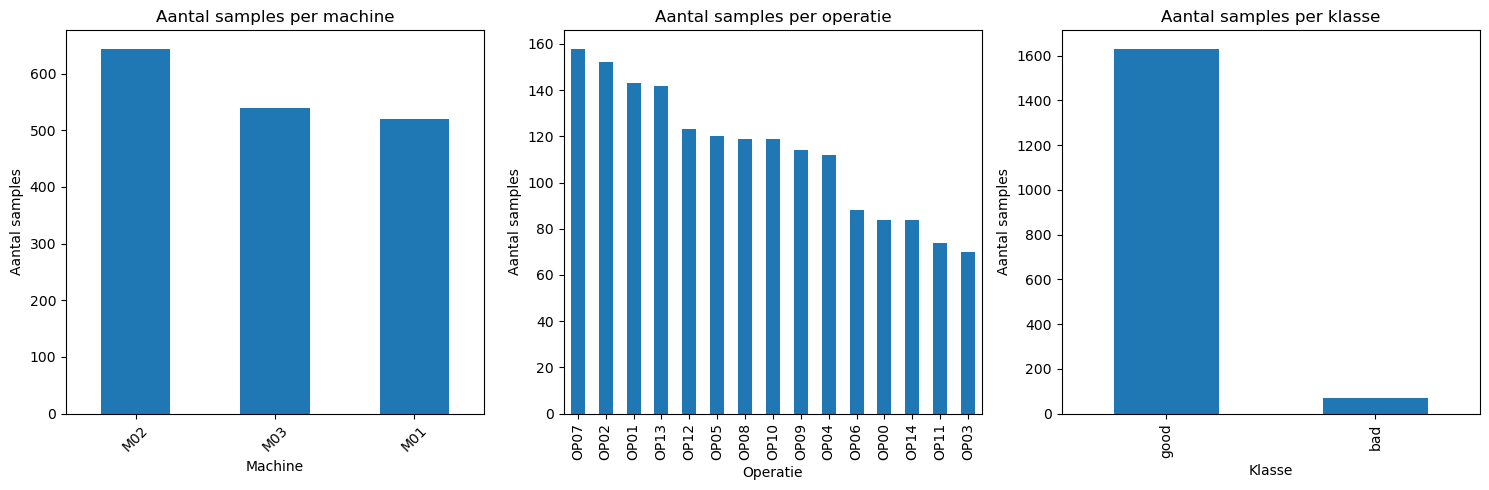

In [25]:
# Maak een bar plot van de verdeling van de data over machines, operaties en klassen
import matplotlib.pyplot as plt

# Maak een figuur met subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot voor machine verdeling
df_measurement_files['machine'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Aantal samples per machine')
ax1.set_xlabel('Machine')
ax1.set_ylabel('Aantal samples')
ax1.tick_params(axis='x', rotation=45)

# Plot voor operatie verdeling 
df_measurement_files['operation'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Aantal samples per operatie')
ax2.set_xlabel('Operatie')
ax2.set_ylabel('Aantal samples')
ax2.tick_params(axis='x', rotation=45)

# Plot voor klasse verdeling
df_measurement_files['class'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Aantal samples per klasse')
ax3.set_xlabel('Klasse')
ax3.set_ylabel('Aantal samples')
ax3.tick_params(axis='x', rotation=45)

# Plot voor operatie verdeling 
df_measurement_files['operation'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Aantal samples per operatie')
ax2.set_xlabel('Operatie')
ax2.set_ylabel('Aantal samples')

# Plot voor klasse verdeling
df_measurement_files['class'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Aantal samples per klasse')
ax3.set_xlabel('Klasse')
ax3.set_ylabel('Aantal samples')

fig.tight_layout()
plt.show()


# Export the plot to a file
# fig.savefig('data_distribution.png')

In [22]:
# Print wat statistieken
print("\nDataset statistieken:")
print(f"Totaal aantal samples: {len(df_measurement_files)}")
print("\nVerdeling per machine:")
print(df_measurement_files['machine'].value_counts())
print("\nVerdeling per operatie:")
print(df_measurement_files['operation'].value_counts())
print("\nVerdeling per klasse:")
print(df_measurement_files['class'].value_counts())


print("mean:",df_measurement_files['measurements'].mean())
print("std:",df_measurement_files['measurements'].std())
print("median:",df_measurement_files['measurements'].median())


Dataset statistieken:
Totaal aantal samples: 1702

Verdeling per machine:
M02    644
M03    539
M01    519
Name: machine, dtype: int64

Verdeling per operatie:
OP07    158
OP02    152
OP01    143
OP13    142
OP12    123
OP05    120
OP08    119
OP10    119
OP09    114
OP04    112
OP06     88
OP00     84
OP14     84
OP11     74
OP03     70
Name: operation, dtype: int64

Verdeling per klasse:
good    1632
bad       70
Name: class, dtype: int64
mean: 104936.09870740306
std: 60507.87696581117
median: 87040.0
